# End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1.Problem
Identifying the breed of a dog given an image of a dog.

Given a photo of a dog, we want to know breed of the dog.

## 2. Data

The data we're using is from Kaggle's dog breeed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilites for each dog breed for each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data), so we are using deep learning/transfer learning.

* There are 120 breeds of dogs (this means there are 120 different classes).

* There are around 10000+ images in the training set (these images have labels).

* There are around 10000+ images in the test set( labels of these images are to be predicted).


###  Get our workspace ready




In [1]:
# Import necessary tools

import tensorflow as tf
import tensorflow_hub as hub
import os
import numpy as np
import pandas as pd

print("TF version",tf.__version__)
print('TF hub version',hub.__version__)

# Check for GPU availabality
print ('GPU','available' if tf.config.list_physical_devices('GPU')else 'not available')

TF version 2.3.0
TF hub version 0.9.0
GPU available


## Getting our data ready (turning into Tensors)

For all machine learning models, our data has to be in numerical format. 

In [2]:
#Checkout the labels of our data
import pandas as pd
labels_csv=pd.read_csv("/content/drive/My Drive/dogbreeddata/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     0192d7174233ebdb3d720000413829ac  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


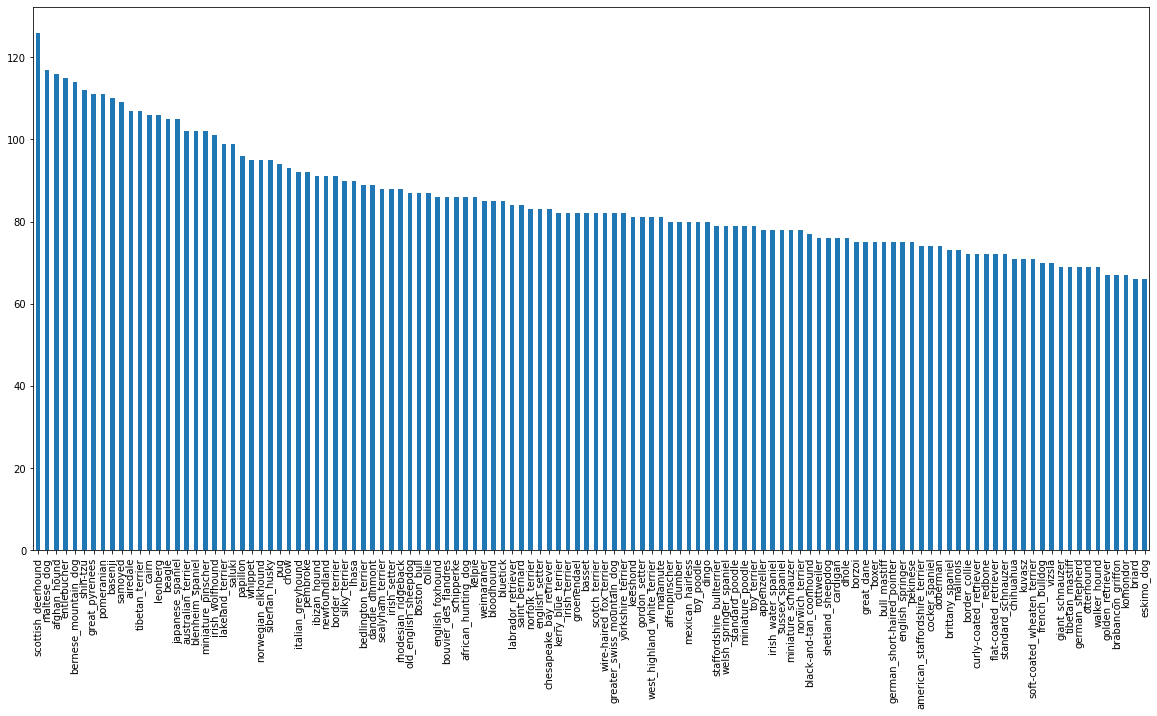

In [3]:
# No of images for each breed

labels_csv['breed'].value_counts().plot.bar(figsize=(20,10));

In [4]:
labels_csv['breed'].value_counts().median()

82.0

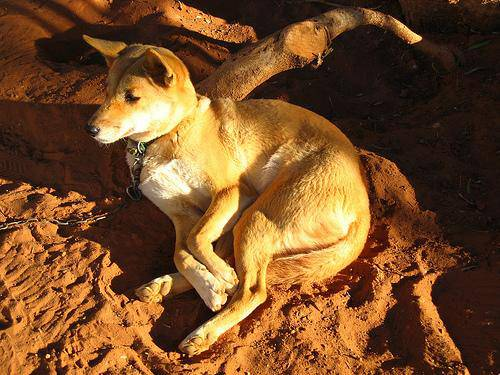

In [5]:
#Let's view an image

from IPython.display import Image

Image('/content/drive/My Drive/dogbreeddata/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg')

### Getting images and their labels

Getting list of all our image file pathnames

In [6]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [7]:
#Create pathnames from image ID's

filenames=['/content/drive/My Drive/dogbreeddata/train/'+fname+'.jpg' for fname in labels_csv.id]

filenames[:10]

['/content/drive/My Drive/dogbreeddata/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/My Drive/dogbreeddata/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/My Drive/dogbreeddata/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/My Drive/dogbreeddata/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/My Drive/dogbreeddata/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/My Drive/dogbreeddata/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/My Drive/dogbreeddata/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/My Drive/dogbreeddata/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/My Drive/dogbreeddata/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/My Drive/dogbreeddata/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [8]:
#Check no of filenames matches number of actual image files

import os

if len(os.listdir('/content/drive/My Drive/dogbreeddata/train'))==len(filenames):
  print('Filenames match actual amount of files')
else:
  print('Filenames doesnt match actual amount of files')



Filenames match actual amount of files


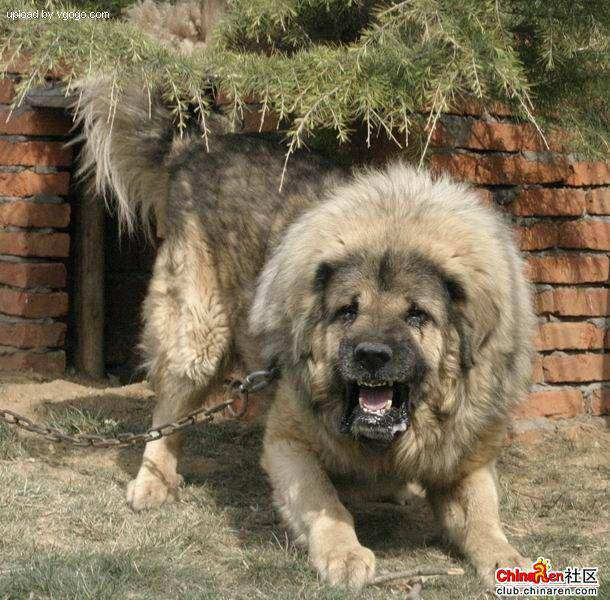

In [9]:
Image(filenames[9000])

In [10]:
labels_csv['breed'][9000]

'tibetan_mastiff'

With training image filepaths in a list, we need to prepare our labels

In [11]:
import numpy as np
labels= labels_csv['breed']
labels=np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [12]:
# Check if number items matches the number of filenames

if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
    print('Number of labels does not match number of filenames')

Number of labels matches number of filenames!


In [13]:
# Find the unique label values

unique_breeds=np.unique(labels)
len(unique_breeds)

120

In [14]:
#Turn a single label into a array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [15]:
# Turn every label into a boolean array
boolean_labels=[label==unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [16]:
# Turning boolean array into integers
print(labels[0]) #original label
print(np.where(unique_breeds==labels[0])) #index where label occurs
print(boolean_labels[0].argmax()) #index where label occurs in a boolean array
print(boolean_labels[0].astype(int)) #there will be a 1 where sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set

Since the dataset from Kaggle doesn't come with validation set.. we are making our own.

In [17]:
# Setup X and y variables

X=filenames
y=boolean_labels

Starting off experimentation with ~1000 images and increase as need

In [18]:
#Set a number of images to use for experimenting

NUM_IMAGES= 2000  #@param {type:"slider",min:1000,max:10000,step :1000}

In [19]:
#Lets split our data into train and validation sets

from sklearn.model_selection import train_test_split

#Split them into training and validation of total NUM_IMAGES

X_train,X_val,y_train,y_val=train_test_split(X[:NUM_IMAGES],
                                             y[:NUM_IMAGES],
                                             test_size=0.2,
                                             random_state=42)
print(len(X_train), len(y_train), len(X_val), len(y_val))

1600 1600 400 400


In [20]:
X_train[:2],y_train[:2]

(['/content/drive/My Drive/dogbreeddata/train/17c5e8815cf0d086090a07b003b9b036.jpg',
  '/content/drive/My Drive/dogbreeddata/train/0593e37870ee77b0d34508e118bf6670.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
          True, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, 

## Preprocessing Images (Turning Images into Tensors)


To preprocess our images to Tensors, we're going to write a function for:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our `image` (convert color channel values from 0-255 to 0-1).
5. Resize the `image` to be a shape of (224,224)
6. Return the modified `image`

In [21]:
#Convert image to Numpy array

from matplotlib.pyplot import imread


image=imread(filenames[72])

#Turn image into tensor
tf.constant(image[:2])

<tf.Tensor: shape=(2, 500, 3), dtype=uint8, numpy=
array([[[228, 246, 250],
        [229, 247, 251],
        [230, 248, 252],
        ...,
        [ 63,  84, 103],
        [ 80, 101, 120],
        [ 87, 108, 127]],

       [[228, 246, 250],
        [229, 247, 251],
        [230, 248, 252],
        ...,
        [ 56,  77,  96],
        [ 74,  95, 114],
        [ 78,  99, 118]]], dtype=uint8)>

In [22]:
#Define image size
IMG_SIZE= 224

#Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  #Read in an image file
  image= tf.io.read_file(image_path)
  #Turn the jpeg image into numerical Tensor with 3 colour channels(Red,Green,Blue)
  image=tf.image.decode_jpeg(image, channels=3)
  #Convert the colour channel values from 0-255 to 0-1 values
  image=tf.image.convert_image_dtype(image, tf.float32)
  #Resize the image to our desired value (224,224)
  image=tf.image.resize(image,size= [IMG_SIZE,IMG_SIZE])
  
  return image

## Turning our data into batches

Instead of processing 10000+ images in one go, we do them in batches of 32.

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this : `(image,label)`

In [23]:
#Create a simple function to return a tuple (image,label)

def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label, processes the image and returns a tuple of (image,label).
  """
  image= process_image(image_path)
  return (image,label)

In [24]:
get_image_label(X[42], y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

We have our Tuples of Tensors ready in the form of `(image, label)` , now a function to turn all of our data `(X,y)` into batches...

In [25]:
# defining batch size to 32

BATCH_SIZE=32

#Create a function to turn data into batches

def create_data_batches(X,y=None, batch_size=BATCH_SIZE, valid_data=False, test_data= False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  If its training data, it shuffles the data but doesn't shuffle if it's validation data.

  Also accepts test data as input(no labels).
  """
  #If the data is a valid dataset, we dont need to shuffle it
  if test_data:
    print('Creating test data batches..')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  #If the data is a valid dataset, we dont need to shuffle it
  elif valid_data:
    print('Creating validation data batches..')
    data=tf.data.Dataset.from_tensor_slices((tf.constant(X), #filepaths
                                            tf.constant(y))) #labels
    data_batch=data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print('Creating training data batches...')
    #Turn filepaths and labels into Tensors
    data= tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                             tf.constant(y)))
    
    #Shuffling pathnames and labels before mapping image processor function is faster than shuffling images.
    data= data.shuffle(buffer_size=len(X))

    #Turning the training data into batchnames
    data_batch=data.map(get_image_label).batch(BATCH_SIZE)

    return data_batch

In [26]:
#Create training and validation data batches.

train_data= create_data_batches(X_train,y_train)
val_data=create_data_batches(X_val,y_val,valid_data=True)

Creating training data batches...
Creating validation data batches..


In [27]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [28]:
#Checking different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now in batches, however these can be little hard to understand, lets visualize them.

In [36]:
import matplotlib.pyplot as plt

#Create a function for viewing images in a data batch

def show_25_images(images,labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  #Setup the figure
  plt.figure(figsize=(10,10))
  #Loop through 25 (for displaying 25 images)
  for i in range(25):
    #Create subplot (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    #Display an image
    plt.imshow(images[i])
    #Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    #Turn the grid lines off
    plt.axis('off')

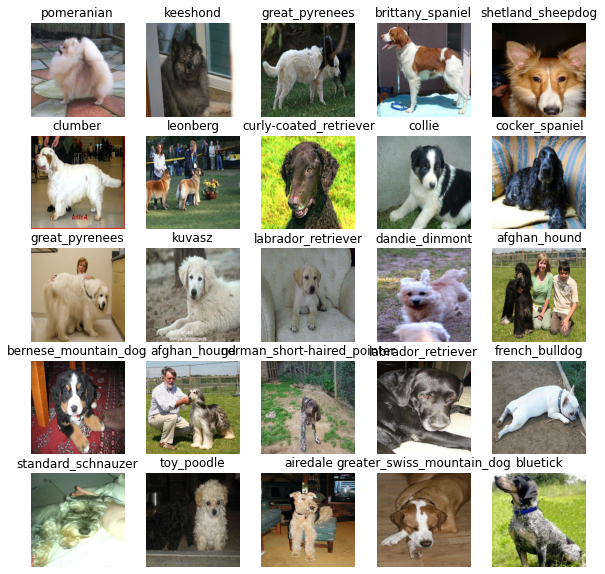

In [40]:
#Now let's visualize the data in a training batch
train_images,train_labels=next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

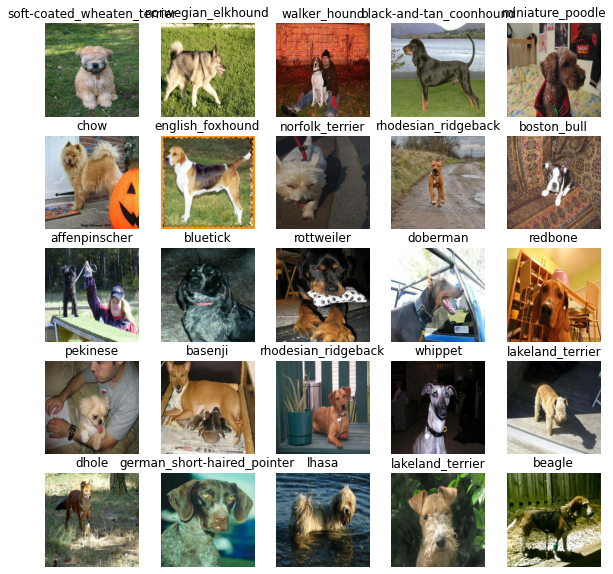

In [39]:
#Now let's visualize our validation set

val_images,val_labels=next(val_data.as_numpy_iterator())
show_25_images(val_images,val_labels)

## Building a model
Before building the model , we need to define the following:
* The `input` shape to our model.
* The `output` shape of our model.
* The URL of the model we want to use from TensorFlow Hub: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [43]:
#Setup image shape to the model

INPUT_SHAPE= [None ,IMG_SIZE,IMG_SIZE,3] #batch, height, width, colour channels

#Setup output shape of our model

OUTPUT_SHAPE= len(unique_breeds)

#Setup model URL from TensorFlow Hub

MODEL_URL= "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

With the inputs, outputs and model ready, lets put them all together into a Keras deep learning model!

Knowing this, let's create a function which:

* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras Model
* Compiles the model
* Builds the model.
* Returns the model.

In [45]:
#Create a function which builds a Keras model

def create_model(input_shape=INPUT_SHAPE, output_shape= OUTPUT_SHAPE , model_url=MODEL_URL):
  print('Building model with ', MODEL_URL)

  #Setup the model layers
  model= tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), #Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation='softmax')
  ])

  #Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy']
  )

  #Build the model

  model.build(INPUT_SHAPE)

  return model

In [46]:
model=create_model()
model.summary()

Building model with  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________
